# Feature Store with Aerospike
This notebook shows how Aerospike can be used as a feature store.

## Introduction
This notebook demonstrates in Python how Aerospike can be used as an online feature store. In the first part, it explains and implements the key objects, data model, and operations. In the second part, it uses them in an end-to-end ML prediction scenraio from feature engineering, model training, to model serving.

## Prerequisites
This tutorial assumes familiarity with the following topics:

- Aerospike Notebooks - Readme and Tips
- Hello World
- PySpark

## Setup

### Ensure Database Is Running
This notebook requires that Aerospike datbase is running.

In [51]:
!asd >& /dev/null
!pgrep -x asd >/dev/null && echo "Aerospike database is running!" || echo "**Aerospike database is not running!**"

Aerospike database is running!


### Initialize Spark

#### Initialize Paths and Env Variables

In [52]:
# directory where spark notebook requisites are installed
#SPARK_NB_DIR = '/home/jovyan/notebooks/spark'
SPARK_NB_DIR = '/opt/spark-nb'
SPARK_HOME = SPARK_NB_DIR + '/spark-3.0.0-bin-hadoop3.2'

In [53]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="localhost"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AEROSPIKE_SPARK_JAR_VERSION="3.1.0"
AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [54]:
# Next we locate the Spark installation - this will be found using the SPARK_HOME environment variable that you will have set 
import findspark
findspark.init(SPARK_HOME)

In [55]:
# Aerospike Spark Connector related settings
import os 
AEROSPIKE_JAR_PATH= "aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + SPARK_NB_DIR + '/' + AEROSPIKE_JAR_PATH + ' pyspark-shell'

#### Configure Spark Session
Please visit [Configuring Aerospike Connect for Spark](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html) for more information about the properties used on this page.

In [56]:
# imports
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType, DoubleType

In [57]:
sc = SparkContext.getOrCreate()
conf=sc._conf.setAll([("aerospike.namespace",AS_NAMESPACE),("aerospike.seedhost",AS_CONNECTION_STRING)])
sc.stop()
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

### Access Shell Commands
You may execute shell commands including Aerospike tools like [aql](https://docs.aerospike.com/docs/tools/aql/index.html) and [asadm](https://docs.aerospike.com/docs/tools/asadm/index.html) in the terminal tab throughout this tutorial. Open a terminal tab by selecting File->Open from the notebook menu, and then New->Terminal.

# Feature Store: Definition and Simple Implementation
In this notebook, we will implement and use the following key objects:
- Feature Groups
- Features
- Feature Values
- Datasets

## Feature Store Objects and Data Model
### Features Group
One way to organize ML features is by grouping them by the source of data and/or processing pipeline. A Feature Group includes many features, and has the following attributes that are useful during feature exploration:
- name: a unique name (a string)
- description: the description of the feature group
- source: source of fact data 

A feature group is stored in the set "fg-metadata".

### Feature
A Feature consists of the following attributes:
- id: the record user-key consists of the string concatenation of fg_name and feature name in the form: fg_name|name.
- fg_name: the name of the feature group the feature belongs to
- name: feature name that is unique name within the feature group
- description: human readable description for exploration
- online: a flag indicating if the feature is available online 
- other: other attributes can include various stats, performance, and other info.

A feature group is stored in the set "feature-metadata".

### Feature Value
Feature values are stored for an entity such as a user, credit card, or sensor, and form input records for the ML model datasets. Features in multiple feature groups may be combined for an entity type and their values are stored with each entity instance. A feature values record for an entity has these attributes:
- id: id of the entity instance serves as the record key.
- fvalues: a map of feature id -> value. The value is encoded as a string prefixed with its type indcator. For example, "i12", "sHarry Potter", and "f1.23".
- other: other attributes can include update timestamp, online flag for ease of replication, etc.

Feature values for an entity type are stored in entity-type specific set "entity-type-fvalues". For example, feature values for users are stored in user-fvalues and for credit cards are stored in cc-fvalues. 
    
### Dataset
Datasets hold a selected subset of feature values and entity instances. Only the metadata information is stored in Aerospike while the actual materialization is stored in another store (such as a file system). A dataset record has following attributes.
- name: name of the data set, serves as the key for the record
- description: description of the dataset
- location: location and store details
- features: list of features
- query: query details to enumerate the entity instances in the dataset.

Datasets are stored in the set "dataset-metadata".

## Feature Store Operations
The following operations are implemented for the different use scenarios:
- Feature Engineering
    - Feature Group
        - create (save)
    - Feature
        - create (save)
    - Feature Values
        - create or update (save) individually or from a dataframe

- Model Training
    - Feature Group
        - load (get)
    - Feature
        - query by group and/or other attribute (query by predicate)
    - Feature Values
        - query by predicate to get a dataframe
    - Dataset
        - create (save metadata)

- Model Serving
    - Feature Values
        - get specific feature values for an entity instance

## Feature Store Implementation
The following code is a simple implementation of the above operations. These operations will be illustrated in the next section with an end-to-end example.

### Feature Group Implementation

In [58]:
class FeatureGroup:
    schema = StructType([StructField("name", StringType(), False),
                         StructField("description", StringType(), True),
                         StructField("source", StringType(), True)])
    
    def __init__(self, name, description, source):
            self.name = name
            self.description = description
            self.source = source
            return

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)


    def save(self):
        inputBuf = [(self.name, self.description, self.source)]
        inputRDD = spark.sparkContext.parallelize(inputBuf)            
        inputDF = spark.createDataFrame(inputRDD, FeatureGroup.schema)
        #Write the data frame to Aerospike, the name field is used as the primary key
        inputDF.write \
            .mode('overwrite') \
            .format("aerospike")  \
            .option("aerospike.writeset", "fg_metadata")\
            .option("aerospike.updateByKey", "name") \
            .save()
        return 

    def load(name):
        fg = None
        fgdf = spark.read \
            .format("aerospike") \
            .option("aerospike.set", "fg_metadata") \
            .schema(FeatureGroup.schema) \
            .load().where("name = \"" + name + "\"")  
        if fgdf.count() > 0:
            #fgdf = fgdf.select('name', 'description', 'source')
            fgtuple = fgdf.collect()[0]
            fg = FeatureGroup(*fgtuple)       
        return fg

In [59]:
#test feature group 
fg1 = FeatureGroup("fg_name1", "fg_desc1", "fg_source1")
fg1.save()
# test read
fg2 = FeatureGroup.load("fg_name1")
print(fg2)

<class '__main__.FeatureGroup'>: {'name': 'fg_name1', 'description': 'fg_desc1', 'source': 'fg_source1'}


### Feature Implementation

In [60]:
class Feature:
    schema = StructType([StructField("fid", StringType(), False),
                           StructField("fg_name", StringType(), False),
                           StructField("name", StringType(), False),
                           StructField("description", StringType(), True),
                           StructField("online_flag", IntegerType(), True)])

    def __init__(self, fg_name, name, description, online_flag):
        self.fid = fg_name + '|' + name
        self.fg_name = fg_name
        self.name = name
        self.description = description
        self.online_flag = online_flag
        return
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

    def tuple(self):
        return (self.fg_name, self.name, self.f_description, self.online_flag)
    
    def save(self):
        inputBuf = [(self.fid, self.fg_name, self.name, self.description, self.online_flag)]
        inputRDD = spark.sparkContext.parallelize(inputBuf)            
        inputDF = spark.createDataFrame(inputRDD, Feature.schema)
        #Write the data frame to Aerospike, the name field is used as the primary key
        inputDF.write \
            .mode('overwrite') \
            .format("aerospike")  \
            .option("aerospike.writeset", "feature_metadata")\
            .option("aerospike.updateByKey", "fid") \
            .save()
        return 

    def load(fg_name, name):
        f = None
        f_df = spark.read \
            .format("aerospike") \
            .schema(Feature.schema) \
            .option("aerospike.set", "feature_metadata") \
            .load().where("fid = \"" + fg_name+'|'+name + "\"")  
        #f_df.show();
        if f_df.count() > 0:
            #f_df = f_df.select('fg_name', 'name', 'description', 'online_flag')
            f_tuple = f_df.collect()[0]
            f = Feature(*f_tuple[1:])       
        return f
    
    def queryByGroup(fg_name):
        features = []
        f_df = spark.read \
            .format("aerospike") \
            .schema(Feature.schema) \
            .option("aerospike.set", "feature_metadata") \
            .load().where("fg_name = \"" + fg_name + "\"")  
        #f_df.show()
        #f_df = f_df.select('fg_name', 'name', 'description', 'online_flag')
        for i in range(f_df.count()):
            f_tuple = f_df.collect()[i]
            features.append(Feature(*f_tuple[1:]))
        return features

In [61]:
# test Feature
#test save and load
feature1 = Feature("fg_name1", "f_name1", "f_desc1", 1)
feature1.save()
f1 = Feature.load("fg_name1", "f_name1")
print(f1)
# test query
feature2 = Feature("fg_name1", "f_name2", "f_desc2", 1)
feature2.save()
features = Feature.queryByGroup('fg_name1')
print("Features in feature group fg_name1:")
for f in features:
    print(f)

<class '__main__.Feature'>: {'fid': 'fg_name1|f_name1', 'fg_name': 'fg_name1', 'name': 'f_name1', 'description': 'f_desc1', 'online_flag': 1}
Features in feature group fg_name1:
<class '__main__.Feature'>: {'fid': 'fg_name1|f_name2', 'fg_name': 'fg_name1', 'name': 'f_name2', 'description': 'f_desc2', 'online_flag': 1}
<class '__main__.Feature'>: {'fid': 'fg_name1|f_name1', 'fg_name': 'fg_name1', 'name': 'f_name1', 'description': 'f_desc1', 'online_flag': 1}


### Feature Values Implementation

In [100]:
class FeatureValues:
    schema = StructType([StructField("eid", StringType(), False),
                         StructField("fvalues", MapType(StringType(), StringType()), True)])

    def __init__(self, etype, eid, fvalues):
        self.etype = etype
        self.eid = eid
        self.fvalues = fvalues
        return
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
    def valToDB(value):
        conv = {str:'s', int:'i', float:'f'}
        return conv[type(value)]+str(value)
    
    def valFromDB(vstr):
        t = vstr[0]
        v = vstr[1:]
        return float(v) if t == 'f' else (int(v) if t == 'i' else v)
            
    def fvalsToDB(fvals):
        dbrep = {}
        for f,v in fvals.items():
            dbrep[f] = FeatureValues.valToDB(v)
        return dbrep
    
    def fvalsFromDB(dbrep):
        fvals = {}
        for f,v in dbrep.items():
            fvals[f] = FeatureValues.valFromDB(v)
        return fvals       
        
    def save(self):
        inputBuf = [(self.eid, FeatureValues.fvalsToDB(self.fvalues))]
        inputRDD = spark.sparkContext.parallelize(inputBuf)            
        inputDF = spark.createDataFrame(inputRDD, FeatureValues.schema)
        #Write the data frame to Aerospike, the fg_name field is used as the primary key
        inputDF.write \
            .mode('overwrite') \
            .format("aerospike")  \
            .option("aerospike.writeset", self.etype+'-fvalues')\
            .option("aerospike.updateByKey", "eid") \
            .save()
        return 

    def load(etype, eid):
        fv = None
        fv_df = spark.read \
            .format("aerospike") \
            .schema(FeatureValues.schema) \
            .option("aerospike.set", etype+'-fvalues') \
            .option("aerospike.keyType", "string") \
            .load().where("eid = \"" + eid + "\"")  
        if fv_df.count() > 0:
            #fv_df = fv_df.select('eid', 'fvalues')           
            fv_tuple = fv_df.collect()[0]
            fv = FeatureValues(etype, fv_tuple[0], FeatureValues.fvalsFromDB(fv_tuple[1]))       
        return fv
    
    def saveDF(df, etype, fg_name, eid_column): # save a dataframe
    # df: dataframe consisting of feature values
    # eid_column: column name that holds the eid value
    # fg: feature group of the features
        list_entities = map(lambda row: row.asDict(), df.collect())
        #print("list_entities: ", list_entities)
        inputBuf = [(entity[eid_column], {fg_name+'|'+k : FeatureValues.valToDB(v) \
                                          for k,v in entity.items() if k != eid_column}) for entity in list_entities]
        #print("inputBuf: ", inputBuf)
        inputRDD = spark.sparkContext.parallelize(inputBuf)            
        inputDF = spark.createDataFrame(inputRDD, FeatureValues.schema)
        #inputDF.show()
        #Write the data frame to Aerospike, the name field is used as the primary key
        inputDF.write \
            .mode('overwrite') \
            .format("aerospike")  \
            .option("aerospike.writeset", etype+'-fvalues')\
            .option("aerospike.updateByKey", "eid") \
            .save()
        return 
        
    
    def query(etype, predicate): #returns a dataframe
        def add_map_element(m, k, v): #lambda function
            m[k] = v
            return m
        
        fv_df = spark.read \
            .format("aerospike") \
            .schema(FeatureValues.schema) \
            .option("aerospike.set", etype+'-fvalues') \
            .load().where(predicate)  
        #fv_df = fv_df.select('eid', 'fvalues')
        list_entities = map(lambda row: add_map_element(row[1], '|ID', row[0]), fv_df.collect())
        buf = [{k.partition('|')[2] : FeatureValues.valFromDB(v) for k,v in entity.items()}for entity in list_entities]
        rdd = spark.sparkContext.parallelize(buf)            
        fv_df2 = spark.createDataFrame(rdd)
        return fv_df2
        
    def get_feature_vector(etype, eid, feature_list): # elements in feature_list are in "fg_name|name" form
        # the implementation is shown in Model Serving section with no Spark dependency
        # using Aerospike client
        pass
        

In [63]:
# test Feature Values
# test save and load
fvals1 = {'fg_name1|f_name1' : 1, 'fg_name1|f_name2' : 2.0, 'fg_name1|f_name3' : 'three'}
feature_values1 = FeatureValues('entity_type1', 'eid1', fvals1)
feature_values1.save();
fv1 = FeatureValues.load('entity_type1', 'eid1')
print(fv1)
# test query
fvals2 = {'fg_name1|f_name1' : 10, 'fg_name1|f_name2' : 20.0, 'fg_name1|f_name3' : 'thirty'}
feature_values2 = FeatureValues('entity_type2', 'eid2', fvals2)
feature_values2.save();
print("Instances of entity type entity_type1 with eid ending in 1:")
instances = FeatureValues.query('entity_type1', 'eid like "%1"')
instances.show()
print("Specified instances of entity type entity_type2:")
instances = FeatureValues.query('entity_type2', 'eid in ("eid2")')
instances.show()

<class '__main__.FeatureValues'>: {'etype': 'entity_type1', 'eid': 'eid1', 'fvalues': {'fg_name1|f_name1': 1, 'fg_name1|f_name2': 2.0, 'fg_name1|f_name3': 'three'}}
Instances of entity type entity_type1 with eid ending in 1:
+----+--------------------+
| eid|             fvalues|
+----+--------------------+
|eid1|[fg_name1|f_name1...|
+----+--------------------+

Specified instances of entity type entity_type2:
+----+--------------------+
| eid|             fvalues|
+----+--------------------+
|eid2|[fg_name1|f_name1...|
+----+--------------------+



In [64]:
from pyspark.sql import SparkSession, Row
# test save dataframe
data = [{"ID": 'eid_1', "feature_1": 1, "feature_2": 12.40},
        {"ID": 'eid_2', "feature_1": 2, "feature_2": 30.10},
        {"ID": 'eid_3', "feature_1": 3, "feature_2": 100.01}
        ]

# Create data frame
# create a new ID column if the id column needs to be preserved as a feature 
# using df.withColumn("ID", df["id-feature"])
df = spark.createDataFrame([Row(**i) for i in data])
df.show()
FeatureValues.saveDF(df, "etype_1", "fg_1", "ID")

+-----+---------+---------+
|   ID|feature_1|feature_2|
+-----+---------+---------+
|eid_1|        1|     12.4|
|eid_2|        2|     30.1|
|eid_3|        3|   100.01|
+-----+---------+---------+



### Dataset Implementation

In [65]:
# TBD

# Using Feature Store
In this section, we show how the feature store objects and operations can be leveraged through the various phases of the ML flow.

## Create sample data

In [66]:
# We create age vs salary data, using three different Gaussian distributions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Make sure we get the same results every time this workbook is run
# Otherwise we are occasionally exposed to results not working out as expected
np.random.seed(12345)

# Create covariance matrix from std devs + correlation
def covariance_matrix(std_dev_1,std_dev_2,correlation):
    return [[std_dev_1 ** 2, correlation * std_dev_1 * std_dev_2], 
           [correlation * std_dev_1 * std_dev_2, std_dev_2 ** 2]]

# Return a bivariate sample given means/std dev/correlation
def age_salary_sample(distribution_params,sample_size):
    mean = [distribution_params["age_mean"], distribution_params["salary_mean"]]
    cov = covariance_matrix(distribution_params["age_std_dev"],distribution_params["salary_std_dev"],
                            distribution_params["age_salary_correlation"])
    return np.random.multivariate_normal(mean, cov, sample_size).T

# Define the characteristics of our age/salary distribution
age_salary_distribution_1 = {"age_mean":25,"salary_mean":50000,
                             "age_std_dev":1,"salary_std_dev":5000,"age_salary_correlation":0.3}

age_salary_distribution_2 = {"age_mean":45,"salary_mean":80000,
                             "age_std_dev":4,"salary_std_dev":8000,"age_salary_correlation":0.7}

age_salary_distribution_3 = {"age_mean":35,"salary_mean":70000,
                             "age_std_dev":2,"salary_std_dev":9000,"age_salary_correlation":0.1}

distribution_data = [age_salary_distribution_1,age_salary_distribution_2,age_salary_distribution_3]

# Sample age/salary data for each distributions
sample_size_1 = 100;
sample_size_2 = 120;
sample_size_3 = 80;
sample_sizes = [sample_size_1,sample_size_2,sample_size_3]
group_1_ages,group_1_salaries = age_salary_sample(age_salary_distribution_1,sample_size=sample_size_1)
group_2_ages,group_2_salaries = age_salary_sample(age_salary_distribution_2,sample_size=sample_size_2)
group_3_ages,group_3_salaries = age_salary_sample(age_salary_distribution_3,sample_size=sample_size_3)

ages=np.concatenate([group_1_ages,group_2_ages,group_3_ages])
salaries=np.concatenate([group_1_salaries,group_2_salaries,group_3_salaries])

print("Data created")

Data created


## FEATURE ENGINEERING

### Display simulated age/salary data

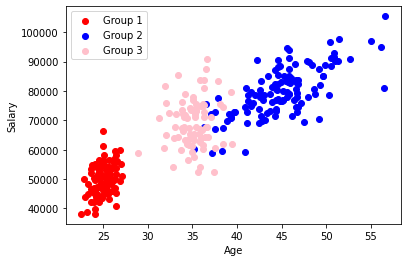

In [67]:
# Plot the sample data
group_1_colour, group_2_colour, group_3_colour ='red','blue', 'pink'
plt.xlabel('Age',fontsize=10)
plt.ylabel("Salary",fontsize=10) 

plt.scatter(group_1_ages,group_1_salaries,c=group_1_colour,label="Group 1")
plt.scatter(group_2_ages,group_2_salaries,c=group_2_colour,label="Group 2")
plt.scatter(group_3_ages,group_3_salaries,c=group_3_colour,label="Group 3")

plt.legend(loc='upper left')
plt.show()

### Save data (Features) to Aerospike

In [50]:
# Turn the above records into a Data Frame
# First of all, create an array of arrays
inputBuf = []

for  i in range(0, len(ages)) :
     id = i + 1 # Avoid counting from zero
     name = "Individual: {:03d}".format(id)
     # Note we need to make sure values are typed correctly
     # salary will have type numpy.float64 - if it is not cast as below, an error will be thrown
     age = float(ages[i])
     salary = int(salaries[i])
     inputBuf.append((id, name,age,salary))

# Convert to an RDD 
inputRDD = spark.sparkContext.parallelize(inputBuf)
       
# Convert to a data frame using a schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("salary",IntegerType(), True)
])

inputDF=spark.createDataFrame(inputRDD,schema)

''' USE THE FEATURE STORE APIS INSTEAD - BELOW
#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()
'''
# Create a feature group
FG_NAME = 'age_sal'
FG_DESCRIPTION = 'Age salary data'
FG_SOURCE = 'generated sample data'
fg = FeatureGroup(FG_NAME, FG_DESCRIPTION, FG_SOURCE)
fg.save()

# create features metadata
FEATURE_NAME = 'name'
f_name = Feature(FG_NAME, FEATURE_NAME, "name of the person", 1)
f_name.save()

FEATURE_AGE = 'age'
f_age = Feature(FG_NAME, FEATURE_AGE, "age of the person", 1)
f_age.save()

FEATURE_SALARY = 'salary'
f_sal = Feature(FG_NAME, FEATURE_SALARY, "salary of the person", 1)
f_sal.save()

# save the feature values
ENTITY_TYPE = 'user'
ID_COLUMN = "id"
FeatureValues.saveDF(inputDF, ENTITY_TYPE, FG_NAME, ID_COLUMN)

Examine the data through aql with the following command:
'''
aql -c "select * from test.user-fvalues"
'''
The output will look like:
'''
select * from test.user-fvalues
+-------+------------------------------------------------------------------------------------------------------------------------+
| eid   | fvalues      |
+-------+------------------------------------------------------------------------------------------------------------------------+
| "62"  | KEY_ORDERED_MAP('{"age_sal|age":"f25.77585254835976", "age_sal|salary":"i51768", "age_sal|name":"sIndividual: 062"}')  |
| "281" | KEY_ORDERED_MAP('{"age_sal|age":"f38.08819977056483", "age_sal|salary":"i75612", "age_sal|name":"sIndividual: 281"}')  |
...
'''

## MODEL TRAINING

## Load data into a DataFrame using user specified schema 

In [101]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

''' USE DATA STORE API TO GET THE DATAFRAME
loadedDFWithSchema=spark \
.read \
.format("aerospike") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()
'''

loadedDFWithSchema = FeatureValues.query(ENTITY_TYPE, "int(eid) > 0")
loadedDFWithSchema.show(5)

+---+------------------+---------------+------+
| ID|               age|           name|salary|
+---+------------------+---------------+------+
|  2| 25.77585254835976|Individual: 062| 51768|
| 81| 38.08819977056483|Individual: 281| 75612|
| 26| 45.82761289603616|Individual: 126| 91152|
| 42| 42.56064799325679|Individual: 142| 80357|
| 11|45.089995066293625|Individual: 111| 76434|
+---+------------------+---------------+------+
only showing top 5 rows



## Sampling from Aerospike DB

- Sample specified number of records from Aerospike to considerably reduce data movement between Aerospike and the Spark clusters. Depending on the aerospike.partition.factor setting, you may get more records than desired. Please use this property in conjunction with Spark `limit()` function to get the specified number of records. The sample read is not randomized, so sample more than you need and use the Spark `sample()` function to randomize if you see fit. You can use it in conjunction with `aerospike.recordspersecond` to control the load on the Aerospike server while sampling.

- For more information, please see [documentation](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html) page.

## Data Exploration with Aerospike 

In [102]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

#convert Spark df to pandas df
pdf = loadedDFWithSchema.toPandas()

# Describe the data

pdf.describe()

,age,salary
count,300.000000,300.000000
mean,35.671508,66952.626667
std,8.985810,14876.009907
min,22.513878,38148.000000
25%,25.773766,53387.000000
50%,35.651953,69062.500000
75%,44.030919,78533.750000
max,56.636219,105414.000000


22 57


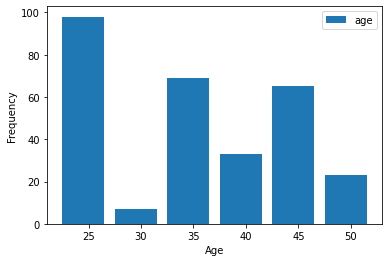

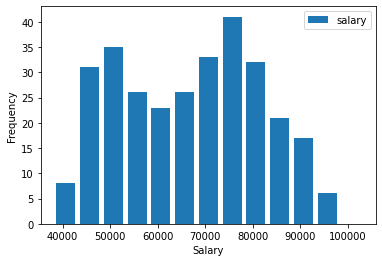

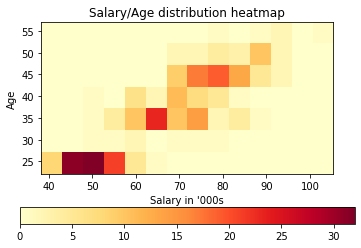

In [103]:
#Histogram - Age
age_min, age_max = int(np.amin(pdf['age'])), math.ceil(np.amax(pdf['age']))
age_bucket_size = 5
print(age_min,age_max)
pdf[['age']].plot(kind='hist',bins=range(age_min,age_max,age_bucket_size),rwidth=0.8)
plt.xlabel('Age',fontsize=10)
plt.legend(loc=None)
plt.show()

#Histogram - Salary
salary_min, salary_max = int(np.amin(pdf['salary'])), math.ceil(np.amax(pdf['salary']))
salary_bucket_size = 5000
pdf[['salary']].plot(kind='hist',bins=range(salary_min,salary_max,salary_bucket_size),rwidth=0.8)
plt.xlabel('Salary',fontsize=10)
plt.legend(loc=None)
plt.show()

# Heatmap
age_bucket_count = math.ceil((age_max - age_min)/age_bucket_size)
salary_bucket_count = math.ceil((salary_max - salary_min)/salary_bucket_size)

x = [[0 for i in range(salary_bucket_count)] for j in range(age_bucket_count)]
for i in range(len(pdf['age'])):
    age_bucket = math.floor((pdf['age'][i] - age_min)/age_bucket_size)
    salary_bucket = math.floor((pdf['salary'][i] - salary_min)/salary_bucket_size)
    x[age_bucket][salary_bucket] += 1

plt.title("Salary/Age distribution heatmap")
plt.xlabel("Salary in '000s")
plt.ylabel("Age")

plt.imshow(x, cmap='YlOrRd', interpolation='nearest',extent=[salary_min/1000,salary_max/1000,age_min,age_max],
           origin="lower")
plt.colorbar(orientation="horizontal")
plt.show()

## Machine Learning using Aerospike / Spark

In this section we use the data we took from Aerospike and apply a clustering algorithm to it.

We assume the data is composed of multiple data sets having a Gaussian multi-variate distribution

We don't know how many clusters there are, so we try clustering based on the assumption there are 1 through 20.

We compare the quality of the results using the Bayesian Information Criterion - https://en.wikipedia.org/wiki/Bayesian_information_criterion and pick the best.
    
### Find Optimal Cluster Count    

In [104]:
from sklearn.mixture import GaussianMixture

# We take the data we previously 
ages=pdf['age']
salaries=pdf['salary']
age_salary_matrix=np.matrix([ages,salaries]).T

# Find the optimal number of clusters
optimal_cluster_count = 1
best_bic_score = GaussianMixture(1).fit(age_salary_matrix).bic(age_salary_matrix)

for count in range(1,20):
    gm=GaussianMixture(count)
    gm.fit(age_salary_matrix)
    if gm.bic(age_salary_matrix) < best_bic_score:
        best_bic_score = gm.bic(age_salary_matrix)
        optimal_cluster_count = count

print("Optimal cluster count found to be "+str(optimal_cluster_count))

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn

Optimal cluster count found to be 4


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn

## Estimate cluster distribution parameters
Next we fit our cluster using the optimal cluster count, and print out the discovered means and covariance matrix

In [105]:
gm = GaussianMixture(optimal_cluster_count)
gm.fit(age_salary_matrix)

estimates = []
# Index
for index in range(0,optimal_cluster_count):
    estimated_mean_age = round(gm.means_[index][0],2)
    estimated_mean_salary = round(gm.means_[index][1],0)
    estimated_age_std_dev = round(math.sqrt(gm.covariances_[index][0][0]),2)
    estimated_salary_std_dev = round(math.sqrt(gm.covariances_[index][1][1]),0)
    estimated_correlation = round(gm.covariances_[index][0][1] / ( estimated_age_std_dev * estimated_salary_std_dev ),3)
    row = [estimated_mean_age,estimated_mean_salary,estimated_age_std_dev,estimated_salary_std_dev,estimated_correlation]
    estimates.append(row)
    
pd.DataFrame(estimates,columns = ["Est Mean Age","Est Mean Salary","Est Age Std Dev","Est Salary Std Dev","Est Correlation"])    


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,Est Mean Age,Est Mean Salary,Est Age Std Dev,Est Salary Std Dev,Est Correlation
0,44.37,76736.0,3.32,4534.0,0.415
1,25.05,49897.0,1.06,5185.0,0.398
2,47.24,87827.0,3.98,6091.0,0.735
3,35.43,68712.0,1.85,7966.0,-0.028


## Original Distribution Parameters

In [106]:
distribution_data_as_rows = []
for distribution in distribution_data:
    row = [distribution['age_mean'],distribution['salary_mean'],distribution['age_std_dev'],
                             distribution['salary_std_dev'],distribution['age_salary_correlation']]
    distribution_data_as_rows.append(row)

pd.DataFrame(distribution_data_as_rows,columns = ["Mean Age","Mean Salary","Age Std Dev","Salary Std Dev","Correlation"])

,Mean Age,Mean Salary,Age Std Dev,Salary Std Dev,Correlation
0,25,50000,1,5000,0.3
1,45,80000,4,8000,0.7
2,35,70000,2,9000,0.1


You can see that the algorithm provides good estimates of the original parameters

# Model Serving

## Get Feature Vector Implementation
The Spark environment may not be available for model serving. Here the Python client library is used to get specific features for a specific entity.

In [ ]:
# get the map items by key list from the map record bin
# use: aerospike_helpers.operations.map_operations.map_get_by_key_list(bin_name, key_list, 
#                                                                return_type, inverted=False, ctx=None)
# initialize client, etc.

## Prediction

We generate new age/salary pairs for each of the distributions and look at how accurate the prediction is

In [ ]:
def prediction_accuracy(model,age_salary_distribution,sample_size):
    # Generate new values
    new_ages,new_salaries = age_salary_sample(age_salary_distribution,sample_size)
    new_age_salary_matrix=np.matrix([new_ages,new_salaries]).T
    # Find which cluster the mean would be classified into
    mean = np.matrix([age_salary_distribution['age_mean'],age_salary_distribution['salary_mean']])
    mean_cluster_index = model.predict(mean)[0]
    # How would new samples be classified
    classification = model.predict(new_age_salary_matrix)
    # How many were classified correctly
    correctly_classified = len([ 1 for x in classification if x  == mean_cluster_index])
    return correctly_classified / sample_size

prediction_accuracy_results = [None for x in range(3)]
for index, age_salary_distribution in enumerate(distribution_data):
    prediction_accuracy_results[index] = prediction_accuracy(gm,age_salary_distribution,1000)

overall_accuracy = sum(prediction_accuracy_results)/ len(prediction_accuracy_results)
print("Accuracies for each distribution : "," ,".join(map('{:.2%}'.format,prediction_accuracy_results)))
print("Overall accuracy : ",'{:.2%}'.format(overall_accuracy))
